# 

# Example optimization
This notebook outlines how:
- the scoring function works
- to create your custom scoring function
- to adapt an optimizer to the scoring function.
- the model is evaluated on the diverse optimization benchmark.

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
import os
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from rdkit import RDLogger

from divopt.evaluation.process_results import compute_diverse_solutions
from divopt.scoring import BenchmarkScoringFunction

RDLogger.DisableLog("rdApp.*")
plt.style.use("ggplot")

In [107]:
# run the method until both budgets are exhausted. Default settings in the paper are 600s and 10k samples
time_budget = 300
sample_budget = 10000

# set the memory parameters. Set both to None to disable memory
memory_distance_threshold = 0.7
memory_score_threshold = 0.5

# some global parameters

In [108]:
scoring_function_dir = "data/scoring_functions/drd2"
scoring_function = BenchmarkScoringFunction(
    scoring_function_dir=scoring_function_dir,
    time_budget=time_budget,
    sample_budget=sample_budget,
    memory_distance_threshold=memory_distance_threshold,
    memory_score_threshold=memory_score_threshold,
    memory_known_active_init=False,
    use_property_constraints=True,
    n_jobs=8,
    print_progress=True,
)

The scoring function can be called using a list of SMILES via the `score_list` method, 
which is compatible with the `guacamol' scoring function interface.

The `__call__` method of the scoring function provides a wrapper around `score_list`.
This method can also be used on a single SMILES string rather than a list.
This provides compatibility with the oracle class used in `mol_opt`.

The scoring function already take care of caching and checking the validity of the SMILES. Internally the memory/diversity filter is applied if the respective arguments `memory_score_threshold` and `memory_distance_threshold` are set.

In [109]:
with open(os.path.join("test/test_smiles.txt"), "r") as f:
    smiles_list = f.read().splitlines()[:20]

scoring_function.start_timer_and_reset()
scoring_function.print_progress = False

scores0 = scoring_function.score_list(smiles_list)
scores1 = scoring_function(smiles_list)
scores2 = [scoring_function(s) for s in smiles_list]

scores0 == scores1 == scores2

True

### Optimization
The scoring function interface assumes that the optimizer is based on an inner loop that jumps between a generation and scoring step. To get your own optimizer running on the benchmark, you need to implement a class with the following interface:

```python
class SomeOptimizer:
    def __init__(self, arg1, ...):
        self.arg1 = arg1
        # ...

    def generate_optimized_molecules(self, scoring_function):
        while not finished:
            # ...
            scores = scoring_function.score_list(smiles_list)
            self.optimization_step(scores)
            # ...
```

In some cases it might be necessary to adapt the code of the optimizer. In some cases 
it suffices to add a wrapper to the scoring function. 

When this is done, the optimizer 



In [110]:
from optimizers.guacamol_baselines.graph_ga.goal_directed_generation import GB_GA_Generator

optimizer = GB_GA_Generator(
    smi_file="data/guacamol_v1_all.smiles",
    population_size=415,
    offspring_size=232,
    generations=1_000_000,
    mutation_rate=0.05845893692037388,
    n_jobs=8,
    random_start=True,
    patience=1000000000000000,
    canonicalize=False,
)

In [111]:
# this starts the timer and resets the cache.
scoring_function.print_progress = True
scoring_function.start_timer_and_reset()
try:
    optimizer.generate_optimized_molecules(scoring_function)
except TimeoutError:
    print("Compute budget exhausted")

Loop 0000000 | Mean score: 0.017 | Max score: 0.370 | Memsize: 0003, Valid 1.000 | 676.729 mols/sec
Loop 0000001 | Mean score: 0.016 | Max score: 0.370 | Memsize: 0003, Valid 1.000 | 4898.040 mols/sec
Loop 0000002 | Mean score: 0.034 | Max score: 0.490 | Memsize: 0003, Valid 1.000 | 820.869 mols/sec
Loop 0000003 | Mean score: 0.068 | Max score: 0.490 | Memsize: 0005, Valid 1.000 | 786.538 mols/sec
Loop 0000004 | Mean score: 0.092 | Max score: 0.490 | Memsize: 0006, Valid 1.000 | 738.828 mols/sec
Loop 0000005 | Mean score: 0.114 | Max score: 0.490 | Memsize: 0009, Valid 1.000 | 702.693 mols/sec
Loop 0000006 | Mean score: 0.119 | Max score: 0.490 | Memsize: 0009, Valid 1.000 | 577.023 mols/sec
Loop 0000007 | Mean score: 0.155 | Max score: 0.490 | Memsize: 0009, Valid 1.000 | 718.565 mols/sec
Loop 0000008 | Mean score: 0.179 | Max score: 0.490 | Memsize: 0010, Valid 1.000 | 686.644 mols/sec
Loop 0000009 | Mean score: 0.181 | Max score: 0.490 | Memsize: 0011, Valid 1.000 | 683.970 mols/sec

In [112]:
# Now we can get the history of scored molecules from the scoring function
df = scoring_function.get_history()
df.tail()

,CanSmiles,Score,Total time [s],Scoring time [s],Generation time [s],Memory time [s]
175847,CCc1ccc2c(c1)CCC(CCN1C3CCC1CC(C=CCNCCCCCNCC=CC...,0.33,299.854617,89.381597,199.132819,11.340201
175848,N#CC1=CC=C(CC2=CCC(CCCCO)CC2)CC1,0.06,299.856697,89.382160,199.134187,11.340350
175849,N#CNCc1ccc2c(c1)CCC(C1=C(CCC3C=CC=CC3)CN(CNC=C...,0.28,299.858778,89.382723,199.135555,11.340500
175850,OC1CCN(CC2=CCC(CC3CCC(CCN4CC=C(N5CCN(F)CC5)CC4...,0.00,299.860858,89.383286,199.136923,11.340649
175851,N#CNCCCNCC=CCl,0.01,299.862938,89.383849,199.138291,11.340798


## Evaluating the optimizer
We can now evaluate the optimizer in a few steps to arrive at the number of unique and diverse hits.


In [113]:
# make the task a little easier for demo purposes
score_threshold = 0.5
distance_threshold = 0.7

# reduce the dataframe to unique molecules and add a column for how many molecules were scored so far
df_unique = df.drop_duplicates(subset="CanSmiles").copy()
df_unique["#Scored molecules"] = np.arange(len(df_unique))

# only keep molecules that pass the score threshold
df_unique_passing_score = df_unique[df_unique["Score"] > score_threshold]

# compute how many diverse molecules we have according to the #Circles metric.
smiles_list: List[str] = df_unique_passing_score["CanSmiles"].to_list()
idx_divers = compute_diverse_solutions(smiles_list, distance_threshold=distance_threshold, algorithm="maxmin")

df_diverse = df_unique_passing_score.iloc[idx_divers]

## Plot the results
Finally, we can plot the results to see how the optimization went.
Here we plot the number of unique and diverse hits as a function of the compute budget.
The numbers given in the paper are the number of diverse hits once the respective compute budget is reached.

In [114]:
divhits_sample_budget = np.searchsorted(df_diverse["#Scored molecules"], sample_budget)
divhits_time_budget = np.searchsorted(df_diverse["Total time [s]"], time_budget)

print(f"Number of diverse hits at sample budget: {divhits_sample_budget}")
print(f"Number of diverse hits at time budget: {divhits_time_budget}")

Number of diverse hits at sample budget: 13
Number of diverse hits at time budget: 85


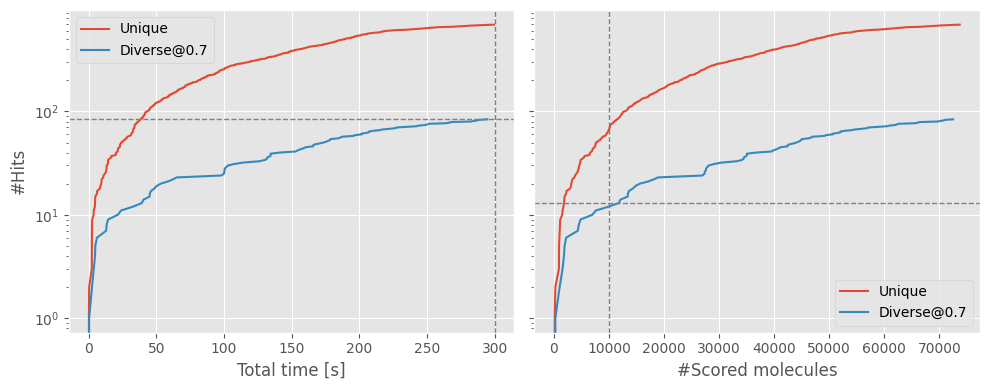

In [115]:
compute_measures = ["Total time [s]", "#Scored molecules"]
compute_budgets = dict(zip(compute_measures, [time_budget, sample_budget]))
divhits = dict(zip(compute_measures, [divhits_time_budget, divhits_sample_budget]))

plot_dfs = {
    "Unique": df_unique_passing_score,
    f"Diverse@{distance_threshold}": df_diverse,
}

fig, axes = plt.subplots(1, ncols=len(compute_measures), figsize=(10, 4), sharey=True)

for i, measure in enumerate(compute_measures):
    for name, plot_df in plot_dfs.items():
        xs = plot_df[measure]
        ys = np.arange(len(plot_df))
        axes[i].plot(xs.values, ys, label=name)

    axes[i].axvline(compute_budgets[measure], color="grey", linestyle="--", lw=1)
    axes[i].axhline(divhits[measure], color="grey", linestyle="--", lw=1)
    axes[i].legend()
    axes[i].set_xlabel(measure)
axes[0].set_ylabel("#Hits")
plt.yscale("log")
plt.tight_layout()